<a href="https://colab.research.google.com/github/MC-Codingcat/NL-COVID-19-Data-Analysis/blob/main/NL%20COVID-19%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploring the Relevance: Urban Density - COVID-19 Infections/Deaths**
<br/><br/>
# Summary  
This report presents an analysis of COVID-19 infections in the Netherlands. The report attempts to compare COVID data with spatial and socio-economic indicators (e.g., built density, average house value, sex, age) to explore the potential links between COVID infections and factors regarding the built environment and individuals' conditions.
###<br/><br/>
# Methodology
### 1. Data collection
The COVID infection data was obtained from RIVM (National Institute for Public Health and the Environment) and the regional (spatial) data from CBS (Statistics Netherlands). Both are public data sources in the Netherlands.
### 2. Exploratory Data Analysis (EDA)
Exploratory analysis techniques were applied to understand the dataset's structure, distributions, and basic statistics.
### 3. Data Cleaning / Wrangling
Data processing steps included handling missing values, data transformation and joining data tables based on key values (e.g., location).
### 4. Statistical Analysis
Statistical methods were used to analyze infection patterns and identify correlations.
### 5. Visualizations
Various visualizations were created to aid in understanding the data.
###<br/><br/>



##Loading data

In [ ]:
# data analysis and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# libraries for geographical and interactive plots
!pip install cufflinks
import cufflinks as cf
%matplotlib inline
cf.go_offline()

# allow reading data files from google drive
from google.colab import drive
drive.mount('/content/drive')

# filter warnings
import warnings
warnings.filterwarnings('ignore')

### Loading COVID data: num. of cases per municipality per day （cumulative）

In [2]:
path = '/content/drive/MyDrive/Colab Notebooks/NL Covid-19 analysis/COVID-19_aantallen_gemeente_cumulatief.csv'
col_names_gmcum = ['Version', 'Date_of_report', 'Date_of_publication', 'Municipality_code', 'Municipality_name', 'Province', 'Total_reported', 'Hospital_admission', 'Deceased']
df_gmcum = pd.read_csv(path, sep = ';', header = 0, names = col_names_gmcum)
df_gmcum.head(3)

,Version,Date_of_report,Date_of_publication,Municipality_code,Municipality_name,Province,Total_reported,Hospital_admission,Deceased
0,8,2020-03-13 10:00:00,2020-03-13 10:00:00,GM0003,Appingedam,Groningen,0,0,0
1,8,2020-03-13 10:00:00,2020-03-13 10:00:00,GM0010,Delfzijl,Groningen,0,0,0
2,8,2020-03-13 10:00:00,2020-03-13 10:00:00,GM0014,Groningen,Groningen,3,0,0


In [3]:
df_gmcum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403206 entries, 0 to 403205
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Version              403206 non-null  int64 
 1   Date_of_report       403206 non-null  object
 2   Date_of_publication  403206 non-null  object
 3   Municipality_code    389421 non-null  object
 4   Municipality_name    389421 non-null  object
 5   Province             402789 non-null  object
 6   Total_reported       403206 non-null  int64 
 7   Hospital_admission   403206 non-null  int64 
 8   Deceased             403206 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 27.7+ MB


In [4]:
df_gmcum.describe()

,Version,Total_reported,Hospital_admission,Deceased
count,403206.0,403206.000000,403206.000000,403206.000000
mean,8.0,10509.478726,3912.204283,832.594860
std,0.0,23978.530957,4842.704924,2690.152387
min,8.0,0.000000,0.000000,0.000000
25%,8.0,667.000000,25.000000,11.000000
50%,8.0,3830.000000,78.000000,28.000000
75%,8.0,12302.000000,9999.000000,61.000000
max,8.0,443708.000000,9999.000000,9999.000000


#### Cleaning the COVID data
####1- Drop the rows with empty cells

In [27]:
df_gmcum.isnull().sum()

Version                     0
Date_of_report              0
Date_of_publication         0
Municipality_code           0
Municipality_name           0
Province                    0
Total_reported              0
Hospital_admission     150569
Deceased                30780
dtype: int64

In [28]:
#check if the range of null values overlays
df_gmcum.dropna(subset=['Municipality_code']).isnull().sum()

Version                     0
Date_of_report              0
Date_of_publication         0
Municipality_code           0
Municipality_name           0
Province                    0
Total_reported              0
Hospital_admission     150569
Deceased                30780
dtype: int64

In [29]:
#drop the cells without location info
df_gmcum.dropna(subset=['Municipality_code'], inplace=True)


####2- Handling abnormal data

The value "9999" in the columns reporting num. of patients deceased/admitted into hospitals is weird and needs to be checked out. This can be caused by delayed registration of cases or a system setup issue.


In [30]:
df_gmcum[df_gmcum['Hospital_admission']==9999]

,Version,Date_of_report,Date_of_publication,Municipality_code,Municipality_name,Province,Total_reported,Hospital_admission,Deceased


In [31]:
df_gmcum[df_gmcum['Deceased']==9999]

,Version,Date_of_report,Date_of_publication,Municipality_code,Municipality_name,Province,Total_reported,Hospital_admission,Deceased


<br><br/>
It is unlikely that the municipalities all have 9999 admissions to hospitals and deceased patients within one day (even if the data is accumulative and there might be a delayed registration). Let's check the data of the days right before the appearance of the value 9999, and the total number of cases compared to the latest data.
<br><br/>

In [32]:
df_gmcum[df_gmcum['Date_of_publication']=='2022-01-17 10:00:00']

,Version,Date_of_report,Date_of_publication,Municipality_code,Municipality_name,Province,Total_reported,Hospital_admission,Deceased
246600,8,2022-01-17 10:00:00,2022-01-17 10:00:00,GM0014,Groningen,Groningen,36896,142.0,63.0
246601,8,2022-01-17 10:00:00,2022-01-17 10:00:00,GM0034,Almere,Flevoland,44409,456.0,124.0
246602,8,2022-01-17 10:00:00,2022-01-17 10:00:00,GM0037,Stadskanaal,Groningen,5213,41.0,23.0
246603,8,2022-01-17 10:00:00,2022-01-17 10:00:00,GM0047,Veendam,Groningen,3854,21.0,19.0
246604,8,2022-01-17 10:00:00,2022-01-17 10:00:00,GM0050,Zeewolde,Flevoland,3970,27.0,17.0
...,...,...,...,...,...,...,...,...,...
246947,8,2022-01-17 10:00:00,2022-01-17 10:00:00,GM1966,Het Hogeland,Groningen,8129,51.0,37.0
246948,8,2022-01-17 10:00:00,2022-01-17 10:00:00,GM1969,Westerkwartier,Groningen,8548,47.0,36.0
246949,8,2022-01-17 10:00:00,2022-01-17 10:00:00,GM1970,Noardeast-Fryslân,Fryslân,8846,86.0,57.0
246950,8,2022-01-17 10:00:00,2022-01-17 10:00:00,GM1978,Molenlanden,Zuid-Holland,11365,65.0,44.0


In [33]:
df_gmcum[df_gmcum['Date_of_publication']=='2022-12-31 10:00:00']

,Version,Date_of_report,Date_of_publication,Municipality_code,Municipality_name,Province,Total_reported,Hospital_admission,Deceased
370901,8,2023-01-03 10:00:00,2022-12-31 10:00:00,GM0014,Groningen,Groningen,110020,NaN,81.0
370902,8,2023-01-03 10:00:00,2022-12-31 10:00:00,GM0034,Almere,Flevoland,98654,NaN,133.0
370903,8,2023-01-03 10:00:00,2022-12-31 10:00:00,GM0037,Stadskanaal,Groningen,13552,NaN,25.0
370904,8,2023-01-03 10:00:00,2022-12-31 10:00:00,GM0047,Veendam,Groningen,11728,NaN,20.0
370905,8,2023-01-03 10:00:00,2022-12-31 10:00:00,GM0050,Zeewolde,Flevoland,10582,NaN,20.0
...,...,...,...,...,...,...,...,...,...
371238,8,2023-01-03 10:00:00,2022-12-31 10:00:00,GM1979,Eemsdelta,Groningen,18042,NaN,32.0
371239,8,2023-01-03 10:00:00,2022-12-31 10:00:00,GM1980,Dijk en Waard,Noord-Holland,42238,NaN,77.0
371240,8,2023-01-03 10:00:00,2022-12-31 10:00:00,GM1982,Land van Cuijk,Noord-Brabant,49113,NaN,142.0
371241,8,2023-01-03 10:00:00,2022-12-31 10:00:00,GM1991,Maashorst,Noord-Brabant,30077,NaN,128.0


In [34]:
df_gmcum[df_gmcum['Date_of_publication']=='2022-12-31 10:00:00']['Deceased'].sum()

22940.0

It can be seen from the tables that the data in the columns "Total_reported", "Hospital_admission", and "Deceased" are all accumulative. The accumulative death toll in October 2023 is 22992, so the data of 31-12-2022 is likely correct. Likewise, the last valid data of the number of admissions is the data of 17-01-2022. For some reason, the data afterward is lost. The data of total reported cases, however, is all valid in the dataset.
<br><br/>

In [35]:
#change "9999" to "NaN"
df_gmcum['Hospital_admission'].replace(9999, np.nan , inplace=True)
df_gmcum['Deceased'].replace(9999, np.nan , inplace=True)

In [36]:
#export the timeline data for time series analysis (another sub-project)
df_gmcum.drop(['Date_of_publication','Municipality_code','Version'],axis=1).to_csv('/content/drive/MyDrive/Colab Notebooks/NL Covid-19 analysis/cumulative-gm.csv')

In [37]:
#delete the redundant columns and change the column name for clarification
df_gm_total = df_gmcum[df_gmcum['Date_of_publication']=='2023-03-31 10:00:00']
df_gm_total.drop(['Version','Date_of_report','Hospital_admission','Deceased'],axis=1,inplace=True)
df_dec = df_gmcum[df_gmcum['Date_of_publication']=='2022-12-31 10:00:00'][['Municipality_code','Deceased']]
df_gm_total = pd.merge(df_gm_total, df_dec, on='Municipality_code')
df_gm_total.rename({'Deceased' : 'Deceased_till_2022'},axis='columns',inplace=True)
df_gm_total.drop(['Date_of_publication','Municipality_code'],axis=1,inplace=True)

In [38]:
df_gm_total

,Municipality_name,Province,Total_reported,Deceased_till_2022
0,Groningen,Groningen,110430,81.0
1,Almere,Flevoland,98978,133.0
2,Stadskanaal,Groningen,13615,25.0
3,Veendam,Groningen,11773,20.0
4,Zeewolde,Flevoland,10615,20.0
...,...,...,...,...
337,Eemsdelta,Groningen,18120,32.0
338,Dijk en Waard,Noord-Holland,42413,77.0
339,Land van Cuijk,Noord-Brabant,49355,142.0
340,Maashorst,Noord-Brabant,30200,128.0


By 2023 there are indeed 342 *gemeenten* (municipalities) in the Netherlands. The death toll data also makes sense.

### Loading and cleaning regional data (per municipality)

In [17]:
df_gemeenten = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NL Covid-19 analysis/Gemeenten_kerncijfers_2023.csv', sep=';', header = 0)
df_gemeenten.head()

,Municipality,Population,Residents per km²,Homes per km²,Num. all business,Num. Handel en horeca,"Num. Gov, Edu and Care",Surface area (km²)
0,Aa en Hunze,25724.0,93.0,41.0,3180.0,500.0,600.0,"278,87"
1,Aalburg,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aalsmeer,33063.0,1645.0,670.0,5065.0,1040.0,580.0,"32,29"
3,Aalten,27244.0,282.0,126.0,2965.0,515.0,460.0,"97,05"
4,Ter Aar,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df_gemeenten['Municipality'].nunique()

727

By 2023, there are 342 municipalities in the Netherlands. The table above contains way more rows (of "municipalities") than it should.

In [19]:
df_gemeenten.dropna(subset=['Num. all business'])['Municipality'].nunique()

342

In [20]:
df_gemeenten.dropna(subset=['Num. all business'], inplace=True)
df_gemeenten

,Municipality,Population,Residents per km²,Homes per km²,Num. all business,Num. Handel en horeca,"Num. Gov, Edu and Care",Surface area (km²)
0,Aa en Hunze,25724.0,93.0,41.0,3180.0,500.0,600.0,"278,87"
2,Aalsmeer,33063.0,1645.0,670.0,5065.0,1040.0,580.0,"32,29"
3,Aalten,27244.0,282.0,126.0,2965.0,515.0,460.0,"97,05"
7,Achtkarspelen,28149.0,275.0,120.0,3225.0,725.0,365.0,"103,98"
9,Alblasserdam,20356.0,2320.0,963.0,2355.0,455.0,320.0,"10,06"
...,...,...,...,...,...,...,...,...
720,Zundert,22518.0,187.0,82.0,3120.0,485.0,325.0,"121,21"
721,Zutphen,48510.0,1186.0,571.0,5985.0,1075.0,1495.0,"42,93"
722,Zwartewaterland,23368.0,284.0,112.0,2615.0,565.0,270.0,"87,86"
725,Zwijndrecht,45018.0,2217.0,1026.0,5000.0,835.0,810.0,"22,77"


### Transforming regional data

Transform all data of total counts to density

In [21]:
type(df_gemeenten['Surface area (km²)'].iloc[0])

str

In [22]:
df_gemeenten['Surface area (km²)'] = df_gemeenten['Surface area (km²)'].str.replace(',', '.')
df_gemeenten['Surface area (km²)'] = df_gemeenten['Surface area (km²)'].astype('float')
df_gemeenten['Population'] = df_gemeenten['Population'].astype('int32')
df_gemeenten['Residents per km²'] = df_gemeenten['Residents per km²'].astype('int32')

In [23]:
df_gemeenten['Density Business']=(df_gemeenten['Num. all business'] / df_gemeenten['Surface area (km²)']).round(decimals=2)
df_gemeenten['Density horeca']=(df_gemeenten['Num. Handel en horeca'] / df_gemeenten['Surface area (km²)']).round(decimals=2)
df_gemeenten['Density public']=(df_gemeenten['Num. Gov, Edu and Care'] / df_gemeenten['Surface area (km²)']).round(decimals=2)
df_gemeenten.drop(['Num. all business','Num. Handel en horeca','Num. Gov, Edu and Care'], axis=1, inplace=True)

Merge the location info with the infection data to make a whole list

In [24]:
df_gemeenten['Municipality'].replace('Beek (L.)', 'Beek', inplace=True)
df_gemeenten['Municipality'].replace("'s-Gravenhage (gemeente)", "'s-Gravenhage", inplace=True)
df_gemeenten['Municipality'].replace('Groningen (gemeente)', 'Groningen', inplace=True)
df_gemeenten['Municipality'].replace('Hengelo (O.)', 'Hengelo', inplace=True)
df_gemeenten['Municipality'].replace('Laren (NH.)', 'Laren', inplace=True)
df_gemeenten['Municipality'].replace('Middelburg (Z.)', 'Middelburg', inplace=True)
df_gemeenten['Municipality'].replace('Rijswijk (ZH.)', 'Rijswijk', inplace=True)
df_gemeenten['Municipality'].replace('Stein (L.)', 'Stein', inplace=True)
df_gemeenten['Municipality'].replace('Utrecht (gemeente)', 'Utrecht', inplace=True)

In [25]:
df = df_gm_total.merge(df_gemeenten, how='left', left_on='Municipality_name', right_on='Municipality')
df.drop(['Municipality_name'], axis=1, inplace=True)
df.isnull().sum()

Province              0
Total_reported        0
Deceased_till_2022    0
Municipality          0
Population            0
Residents per km²     0
Homes per km²         0
Surface area (km²)    0
Density Business      0
Density horeca        0
Density public        0
dtype: int64

### Getting the data for analysis (cumulative infections/deaths - municipalities)


In [26]:
#change the order of the columns so that the table looks tidier and more logical
df=df.iloc[:, [0,3,1,2,4,5,6,7,8,9,10]]
df.head()

,Province,Municipality,Total_reported,Deceased_till_2022,Population,Residents per km²,Homes per km²,Surface area (km²),Density Business,Density horeca,Density public
0,Groningen,Groningen,110430,81.0,238147,1284,661.0,197.96,147.53,23.44,28.87
1,Flevoland,Almere,98978,133.0,222825,1725,702.0,248.77,116.75,19.60,22.89
2,Groningen,Stadskanaal,13615,25.0,32135,273,129.0,119.94,25.60,5.63,3.71
3,Groningen,Veendam,11773,20.0,27616,364,171.0,78.68,31.77,6.86,5.21
4,Flevoland,Zeewolde,10615,20.0,23692,96,38.0,268.86,12.87,2.25,1.97


<br><br/>
## Exploratory Data Analysis (EDA)

### Getting a view



*  The municipalities with the most reported cases




In [50]:
df.nlargest(5,['Total_reported'])[['Province','Municipality','Total_reported']]

,Province,Municipality,Total_reported
106,Noord-Holland,Amsterdam,443708
164,Zuid-Holland,Rotterdam,318211
147,Zuid-Holland,'s-Gravenhage,245475
96,Utrecht,Utrecht,197884
222,Noord-Brabant,Tilburg,116242


* The municipalities with the most deceased cases

In [51]:
df.nlargest(5,['Deceased_till_2022'])[['Province','Municipality','Deceased_till_2022']]

,Province,Municipality,Deceased_till_2022
164,Zuid-Holland,Rotterdam,1185.0
106,Noord-Holland,Amsterdam,1127.0
147,Zuid-Holland,'s-Gravenhage,686.0
201,Noord-Brabant,Eindhoven,451.0
96,Utrecht,Utrecht,327.0


* The municipalities with the highest infection density

In [52]:
df['Infected per k'] =  df.apply(lambda row: round(row.Total_reported/row.Population*1000), axis=1)
df.nlargest(5, ['Infected per k'])[['Province','Municipality','Infected per k']]

,Province,Municipality,Infected per k
87,Utrecht,Bunschoten,591
295,Overijssel,Rijssen-Holten,585
183,Zeeland,Reimerswaal,561
253,Limburg,Horst aan de Maas,552
40,Overijssel,Wierden,544


* The municipalities with the highest mortality rate

In [53]:
df['Death per k'] = df.apply(lambda row: row.Deceased_till_2022/row.Population*1000, axis=1)
df.nlargest(5, ['Death per k'])[['Province','Municipality','Death per k']]

,Province,Municipality,Death per k
279,Noord-Brabant,Cranendonck,2.973478
136,Noord-Holland,Zandvoort,2.907308
153,Zuid-Holland,Krimpen aan den IJssel,2.745390
231,Limburg,Landgraaf,2.743779
125,Noord-Holland,Laren,2.732240


* The municipalities with the highest residential density

In [55]:
df.nlargest(5,['Residents per km²'])[['Province','Municipality','Residents per km²']]

,Province,Municipality,Residents per km²
147,Zuid-Holland,'s-Gravenhage,6827
154,Zuid-Holland,Leiden,5816
115,Noord-Holland,Haarlem,5662
106,Noord-Holland,Amsterdam,4880
142,Zuid-Holland,Capelle aan den IJssel,4777


* The municipalities that are most dense for business

In [54]:
df.nlargest(5,['Density Business'])[['Province','Municipality','Density Business']]

,Province,Municipality,Density Business
147,Zuid-Holland,'s-Gravenhage,935.69
115,Noord-Holland,Haarlem,826.11
106,Noord-Holland,Amsterdam,786.39
154,Zuid-Holland,Leiden,682.42
96,Utrecht,Utrecht,582.75


### Breakdowns by province

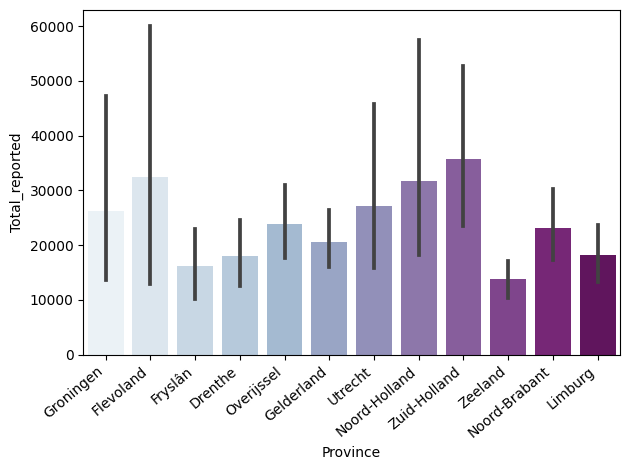

In [44]:
ax = sns.barplot(data=df, x='Province',y='Total_reported',palette='BuPu')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
plt.tight_layout()

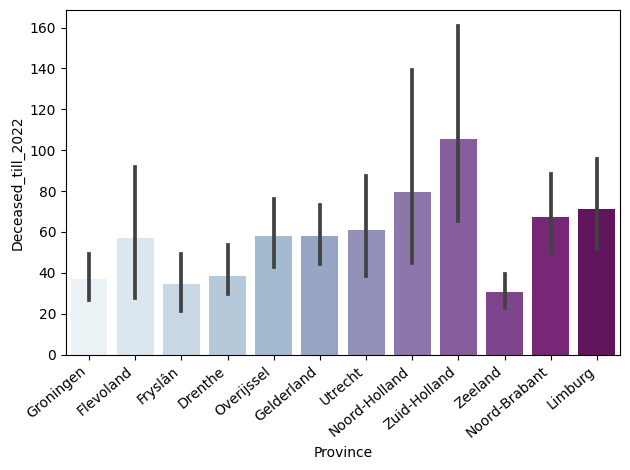

In [45]:
ax = sns.barplot(data=df, x='Province',y='Deceased_till_2022',palette='BuPu')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

<Axes: xlabel='Infected per k', ylabel='Province'>

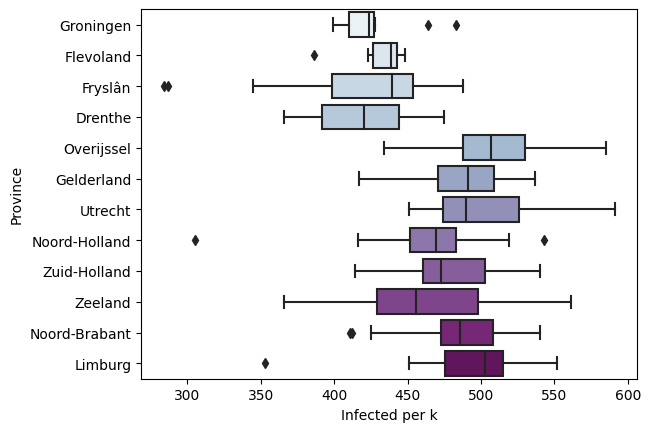

In [46]:
sns.boxplot(y=df['Province'], x=df['Infected per k'],palette='BuPu')

<Axes: xlabel='Death per k', ylabel='Province'>

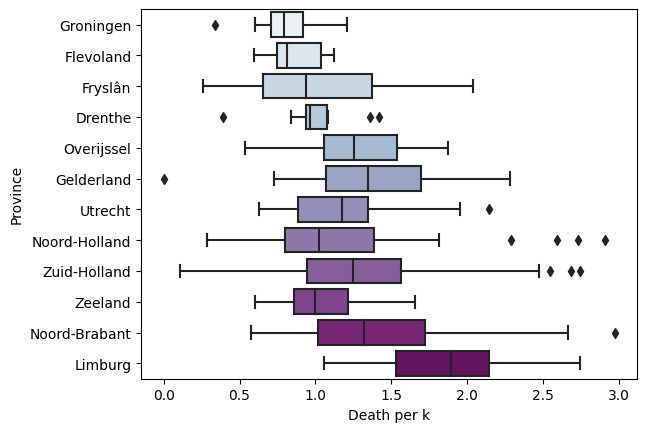

In [47]:
sns.boxplot(y=df['Province'], x=df['Death per k'],palette='BuPu')

### Choropleth maps

In [ ]:
import geopandas as gpd
import requests
import zipfile

# get the shp of municipality boundaries
url_municipalities = 'https://www.cbs.nl/-/media/cbs/dossiers/nederland-regionaal/wijk-en-buurtstatistieken/wijkbuurtkaart_2022_v1.zip'
r = requests.get(url_municipalities)
with open('wijkbuurtkaart_2022_v1.zip', 'wb') as f:
    f.write(r.content)

with zipfile.ZipFile('wijkbuurtkaart_2022_v1.zip', 'r') as zip_ref:
    zip_ref.extractall('gmt_shp')

gmt = gpd.read_file('/content/gmt_shp/WijkBuurtkaart_2022_v1/gemeente_2022_v1.shp')


In [ ]:
# set the index to the municipality column
df.set_index('Municipality', inplace = True)

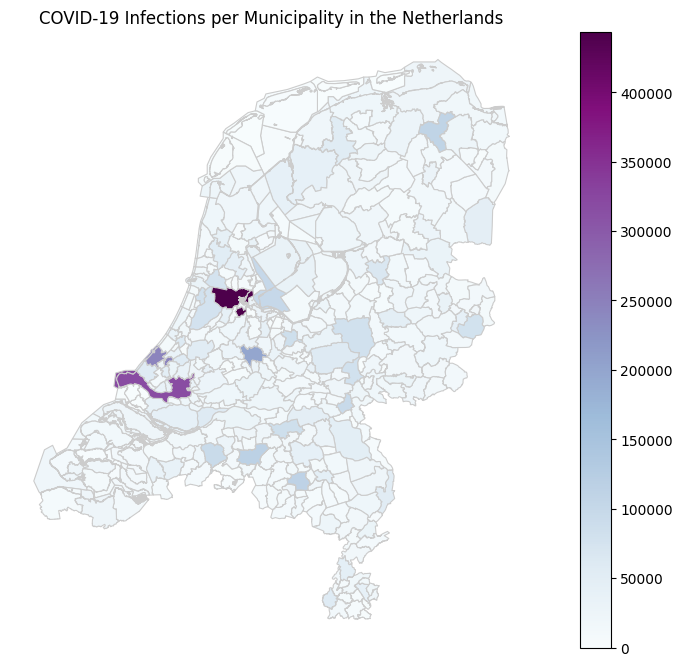

In [97]:
# add infection data to the gmt data frame
gmt['Infections'] = gmt['GM_NAAM'].map(
    lambda x: df['Total_reported'].get(x,0)
)

# plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gmt.plot(column='Infections', cmap='BuPu', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('COVID-19 Infections per Municipality in the Netherlands')
ax.set_axis_off()

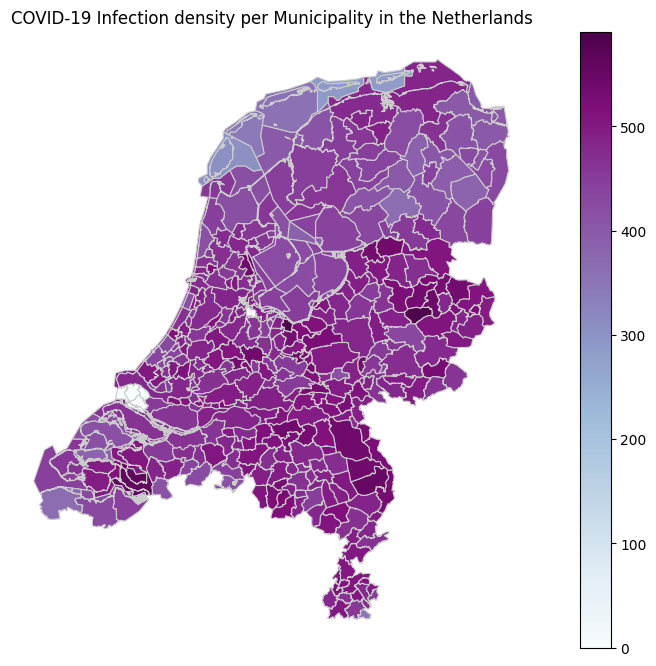

In [98]:
# add infection density data to the gmt data frame
gmt['Infection density'] = gmt['GM_NAAM'].map(
    lambda x: df['Infected per k'].get(x,0)
)

# plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gmt.plot(column='Infection density', cmap='BuPu', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('COVID-19 Infection density per Municipality in the Netherlands')
ax.set_axis_off()

##Exploring the correlation between spatial factors and covid infection and deaths

In [ ]:
df.corr()

,Total_reported,Deceased_till_2022,Population,Residents per km²,Homes per km²,Surface area (km²),Density Business,Density horeca,Density public,Infected per k,Death per k
Total_reported,1.000000,0.944219,0.997710,0.502267,0.524450,0.113094,0.575487,0.551875,0.541091,0.088909,-0.010327
Deceased_till_2022,0.944219,1.000000,0.944817,0.487437,0.511998,0.078135,0.544175,0.532084,0.504463,0.087339,0.188722
Population,0.997710,0.944817,1.000000,0.504803,0.528100,0.127218,0.576169,0.550910,0.539017,0.051763,-0.019306
Residents per km²,0.502267,0.487437,0.504803,1.000000,0.996632,-0.333972,0.959451,0.963832,0.945814,0.077049,0.110569
Homes per km²,0.524450,0.511998,0.528100,0.996632,1.000000,-0.319410,0.962052,0.965198,0.949546,0.060319,0.117516
Surface area (km²),0.113094,0.078135,0.127218,-0.333972,-0.319410,1.000000,-0.326408,-0.351544,-0.314269,-0.366958,-0.238309
Density Business,0.575487,0.544175,0.576169,0.959451,0.962052,-0.326408,1.000000,0.981949,0.982341,0.104767,0.106150
Density horeca,0.551875,0.532084,0.550910,0.963832,0.965198,-0.351544,0.981949,1.000000,0.954418,0.126328,0.132444
Density public,0.541091,0.504463,0.539017,0.945814,0.949546,-0.314269,0.982341,0.954418,1.000000,0.093737,0.093463
Infected per k,0.088909,0.087339,0.051763,0.077049,0.060319,-0.366958,0.104767,0.126328,0.093737,1.000000,0.209942


<Axes: >

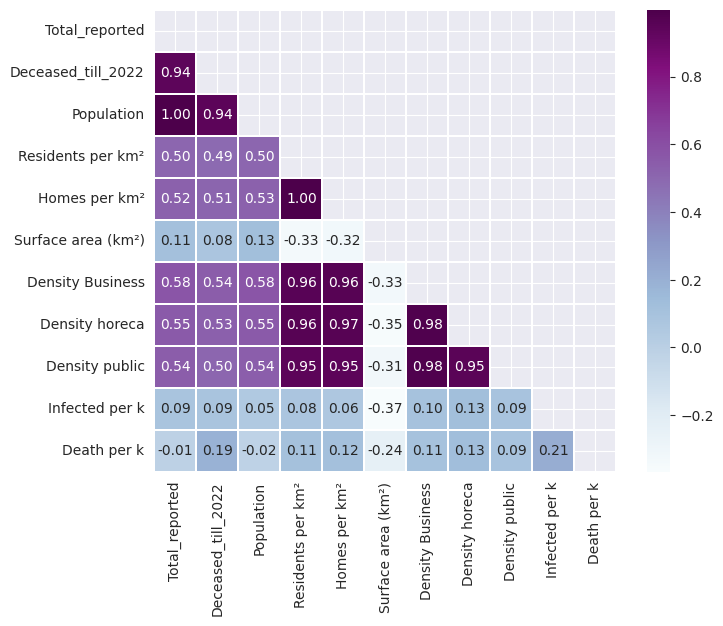

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(8,6))
mask1 = np.triu(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(df.corr(),cmap='BuPu',mask=mask1, square=True, linewidth=0.1, fmt='.2f', annot=True)

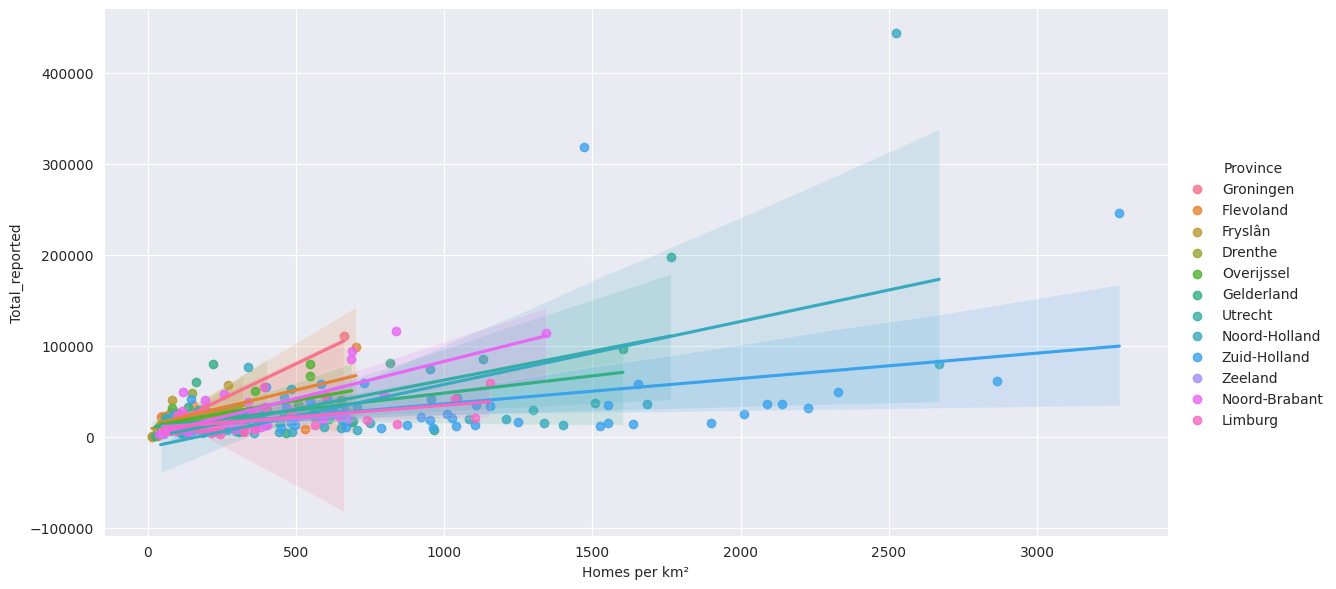

In [ ]:
sns.lmplot(data=df,x='Homes per km²', y='Total_reported',hue='Province',height=6, aspect=2)

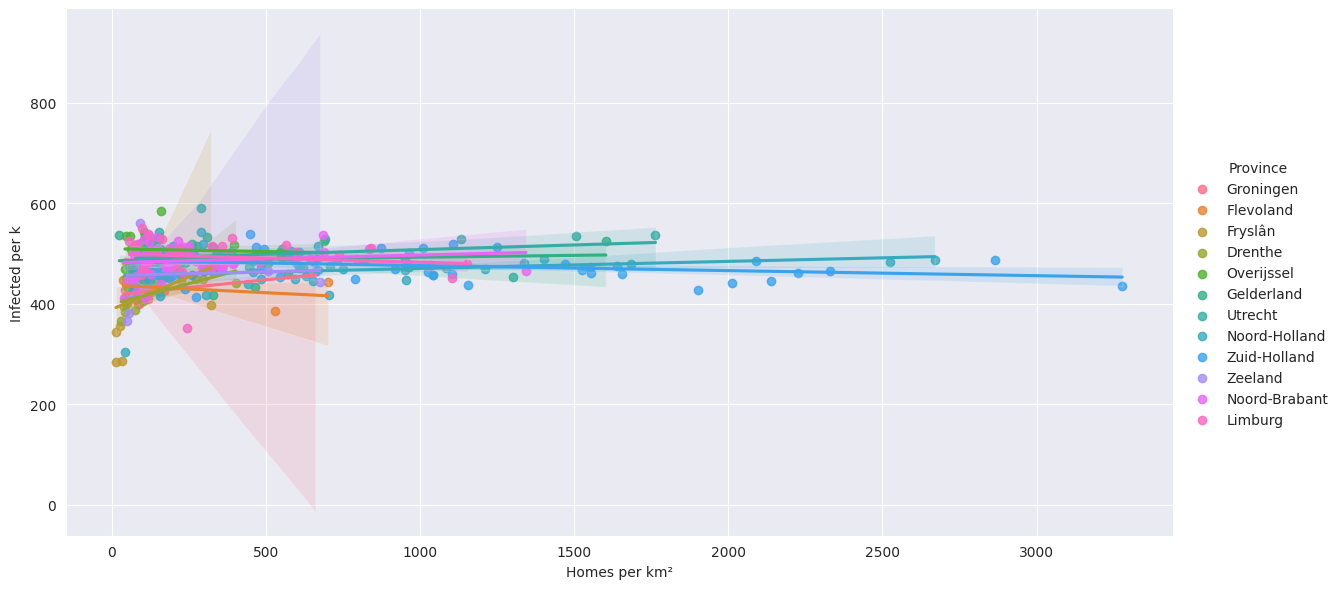

In [ ]:
sns.lmplot(data=df,x='Homes per km²', y='Infected per k',hue='Province',height=6, aspect=2)

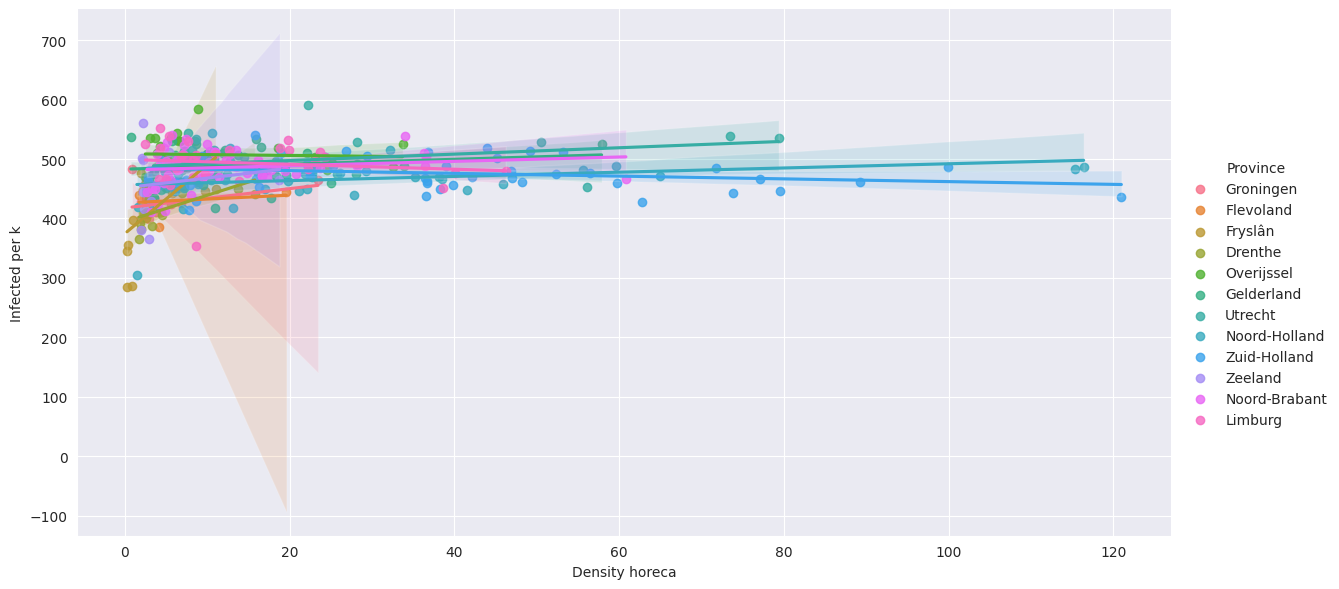

In [ ]:
sns.lmplot(data=df,x='Density horeca', y='Infected per k',hue='Province',height=6, aspect=2)

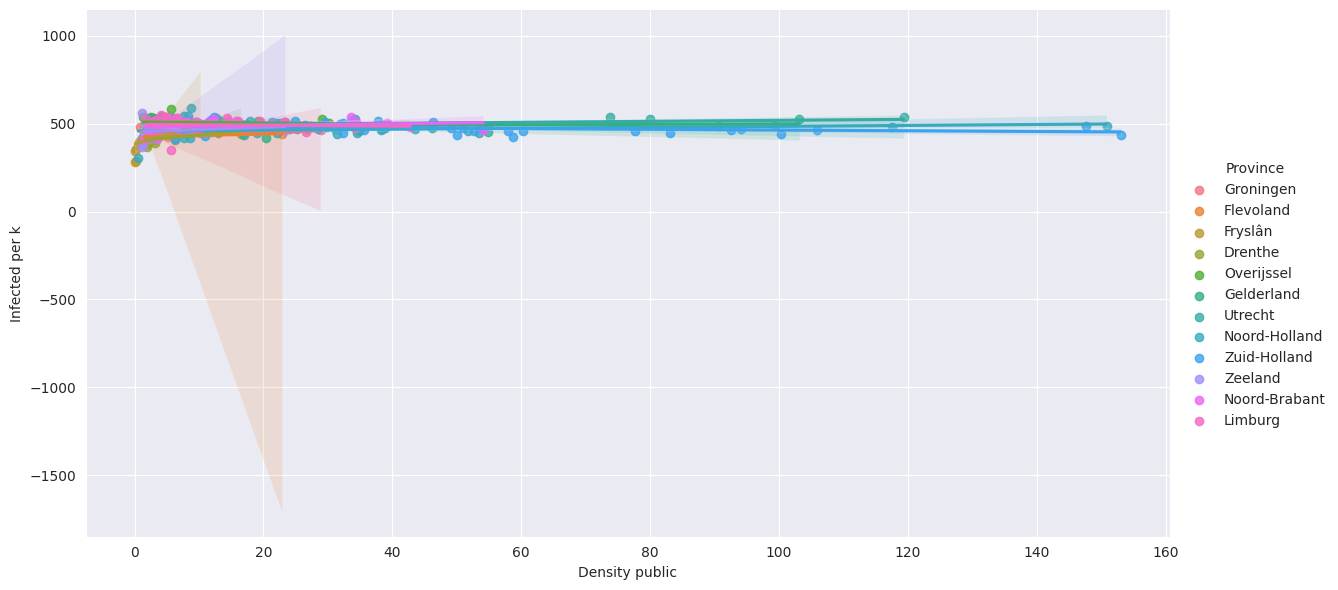

In [ ]:
sns.lmplot(data=df,x='Density public', y='Infected per k',hue='Province',height=6, aspect=2)

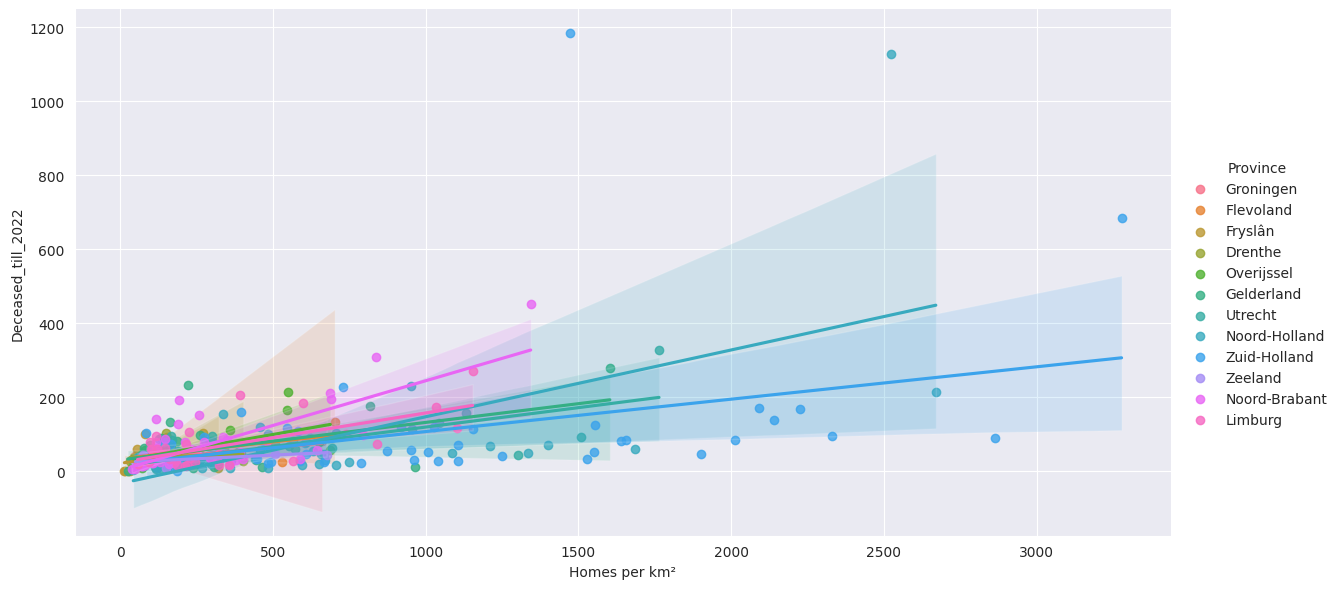

In [ ]:
sns.lmplot(data=df,x='Homes per km²', y='Deceased_till_2022',hue='Province',height=6, aspect=2)

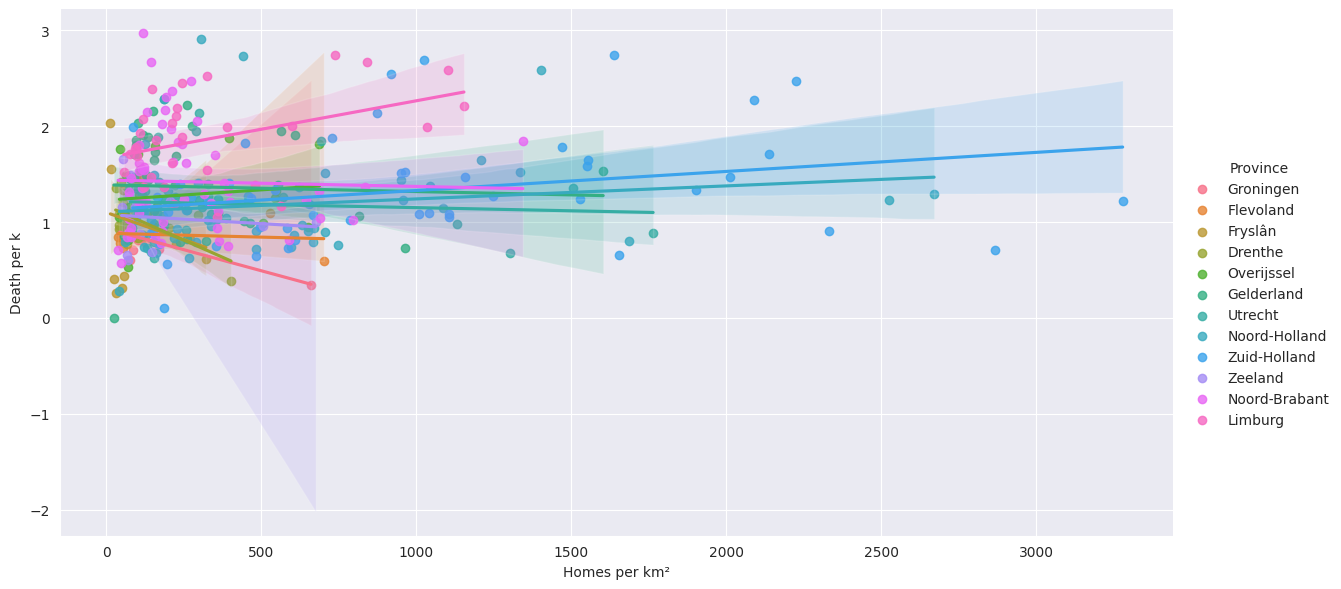

In [ ]:
sns.lmplot(data=df,x='Homes per km²', y='Death per k',hue='Province',height=6, aspect=2)

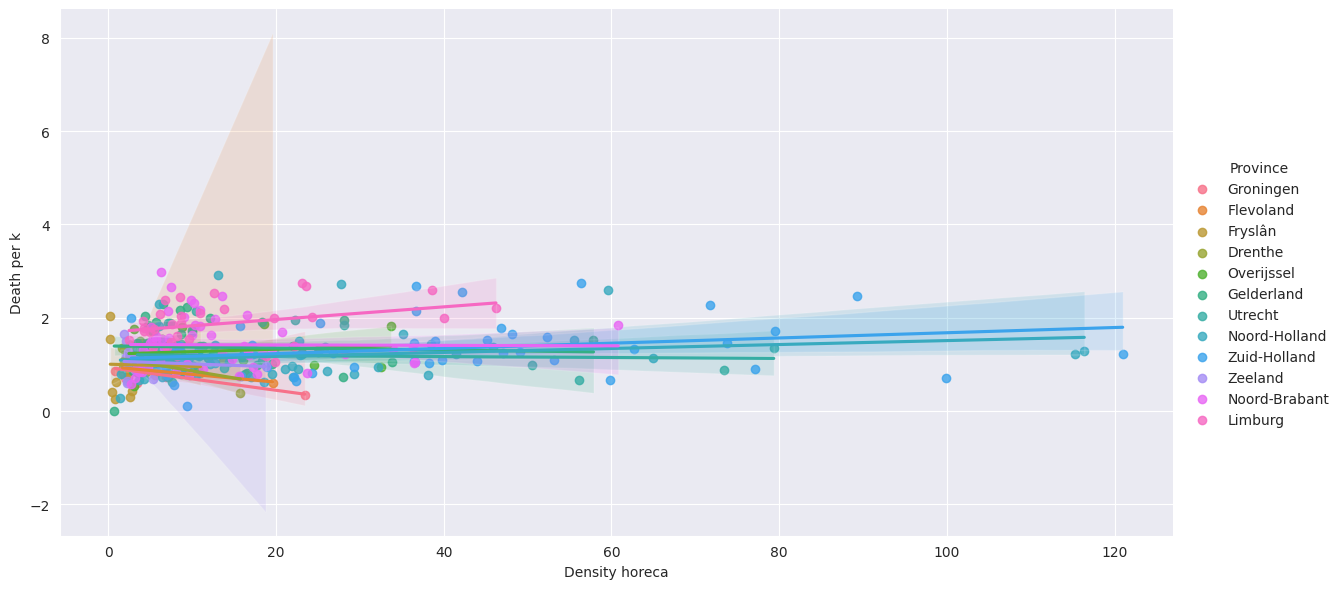

In [ ]:
sns.lmplot(data=df,x='Density horeca', y='Death per k',hue='Province',height=6, aspect=2)

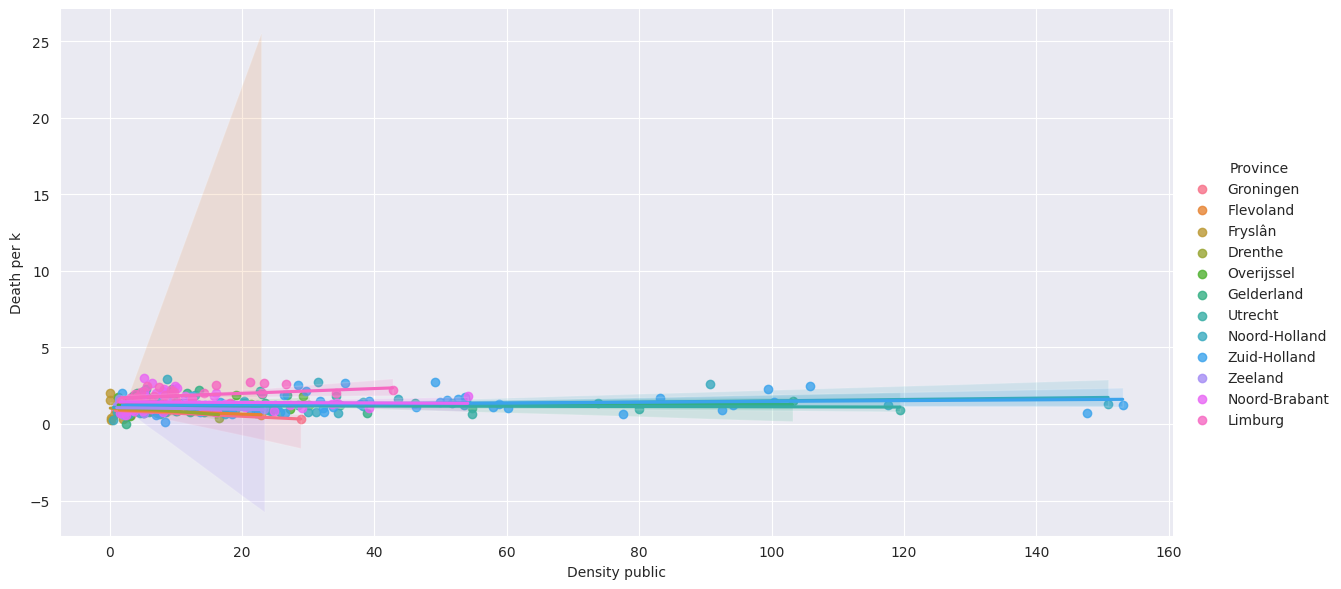

In [ ]:
sns.lmplot(data=df,x='Density public', y='Death per k',hue='Province',height=6, aspect=2)

<br><br/>

## Interactive regression plots per province (Plotly)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'colab'
fig = px.scatter(df,x='Homes per km²', y='Infected per k', hover_name='Municipality',trendline='ols',color='Province')
fig.show()


In [ ]:
fig = px.scatter(df,x='Homes per km²', y='Total_reported', hover_name='Municipality',trendline='ols',color='Province')
fig.show()

In [ ]:
fig = px.scatter(df,x='Density Business', y='Infected per k', hover_name='Municipality',trendline='ols',color='Province')
fig.show()

In [ ]:
fig = px.scatter(df,x='Density horeca', y='Infected per k', hover_name='Municipality',trendline='ols',color='Province')
fig.show()

In [ ]:
fig = px.scatter(df,x='Density public', y='Infected per k', hover_name='Municipality',trendline='ols',color='Province')
fig.show()

In [ ]:
fig = px.scatter(df,x='Homes per km²', y='Deceased_till_2022', hover_name='Municipality',trendline='ols', color='Province')
fig.show()

In [ ]:
fig = px.scatter(df,x='Homes per km²', y='Death per k', hover_name='Municipality',trendline='ols', color='Province')
fig.show()

In [ ]:
fig = px.scatter(df,x='Density Business', y='Death per k', hover_name='Municipality',trendline='ols', color='Province')
fig.show()

In [ ]:
fig = px.scatter(df,x='Density horeca', y='Death per k', hover_name='Municipality',trendline='ols', color='Province')
fig.show()

In [ ]:
fig = px.scatter(df,x='Density public', y='Death per k', hover_name='Municipality',trendline='ols', color='Province')
fig.show()

##Hypothesis testing： regression analysis

From the plots above we can tell that there is no apparent relevance between COVID infections/deaths and the densities of homes, business and public service.
The number of infected/deceased cases does not rise accordingly when the density of urban elements increases; in certain provinces e.g., North Holland, the residential density and the density of facilities are (slightly) negatively related to the density of infections and deaths.

To examine the relevance between urban density (residential density and the density of commercial/public facilities) and COVID infection/deaths, regression analysis is applied to test the hypothethis. For residential density and infections:

$$
    H_0: There is no effect of residential density on infections
      (r=0)
$$

$$
    H_a: There is negative effect of residential density on infections
      (r=0)
$$


In [ ]:
import statsmodels.api as sm

# Add a constant term to the independent variables matrix
X = sm.add_constant(df['Homes per km²'])
y_infections = df['Infected per k']

# Fit the regression model
model_infections = sm.OLS(y_infections, X).fit()

# Print the summary
print(model_infections.summary())

                            OLS Regression Results                            
Dep. Variable:         Infected per k   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.242
Date:                Fri, 24 Nov 2023   Prob (F-statistic):              0.266
Time:                        15:21:59   Log-Likelihood:                -1762.0
No. Observations:                 342   AIC:                             3528.
Df Residuals:                     340   BIC:                             3536.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           473.4952      2.929    161.646

In [ ]:
from scipy.stats import ttest_ind

coef_infections = model_infections.params['Homes per km²']
std_err_infections = model_infections.bse['Homes per km²']

#coef_deaths = model_deaths.params['Urbanization']
#std_err_deaths = model_deaths.bse['Urbanization']

# Calculate t-statistics and p-values
t_stat_infections, p_value_infections = coef_infections / std_err_infections, ttest_ind(df['Homes per km²'], df['Infected per k']).pvalue
#t_stat_deaths, p_value_deaths = coef_deaths / std_err_deaths, 2 * ttest_ind(df['Urbanization'], df['COVID_Deaths']).pvalue

# Compare p-values with significance level (alpha)
alpha = 0.05

print(f"COVID Infections: t-statistic = {t_stat_infections}, p-value = {p_value_infections}")
if p_value_infections < alpha:
    print("Reject the null hypothesis (significant)")
else:
    print("Fail to reject the null hypothesis")

#print(f"\nCOVID Deaths: t-statistic = {t_stat_deaths}, p-value = {p_value_deaths}")
#if p_value_deaths < alpha:
#    print("Reject the null hypothesis (significant)")
#else:
#    print("Fail to reject the null hypothesis")

COVID Infections: t-statistic = 1.1142636874168397, p-value = 0.02466021462408199
Reject the null hypothesis (significant)
